<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/12b_Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

El autoencoder es un algoritmo de aprendizaje profundo no supervisado que aprende representaciones codificadas de los datos de entrada y luego reconstruye la misma entrada como salida.

Consta de dos redes, Encoder y Decoder. El Encoder comprime la entrada de alta dimensión en un código latente de baja dimensión, también llamado código latente o espacio codificado, para extraer de él la información más relevante, mientras que el Decoder descomprime los datos codificados y recrea la entrada original.

El objetivo de esta arquitectura es maximizar la información al codificar y minimizar el error de reconstrucción.

El error de reconstrucción es la pérdida de reconstrucción y suele ser el error cuadrático medio (MSE) entre la entrada reconstruida y la entrada original cuando la entrada tiene un valor real. En caso de que los datos de entrada sean categóricos, la función de pérdida utilizada es Cross-Entropy Loss.

## Conjunto de datos

In [1]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torchvision
import torch

data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:
print (f"Trian loader: {len(train_loader)}")
print (f"Valid loader: {len(valid_loader)}")
print (f"Test loader: {len(test_loader)}")

Trian loader: 188
Valid loader: 47
Test loader: 40


## Autoencoder

El Encoder contendrá tres capas convolucionales y dos capas completamente conectadas. Algunas capas de normalización por lotes que se agregan como regularizadores. El Decoder tendrá la misma arquitectura pero en orden inverso.

In [3]:
from torch import nn

In [28]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        
        # capas convolucionales
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 8, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        # capa para el aplanado
        self.flatten = nn.Flatten(start_dim=1)
        
        # capa lineal
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 8, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 8),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(8, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

Inicializar la función Loss y el optimizado

In [29]:
import torch.nn.functional as F
import torch.optim as optim

# definir la función de pérdida
loss_fn = torch.nn.MSELoss()

# Definir el tasa de aprendizaje del optimizador para ambos (Encoder y Decoder
lr= 0.001

# establecer el valor random
torch.manual_seed(0)

# inicializar las dos redes
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# verificar si hay GPU disponible
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f'Dispositivo seleccionado: {device}\n')

# definir el dispositivo para el Encoder y Decoder
print (encoder.to(device))
print ('-'*100)
print (decoder.to(device))

Dispositivo seleccionado: cuda:0

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=72, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
----------------------------------------------------------------------------------------------------
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=72, bias=True)
    (3): ReLU(inplace=True

## Definir funciones para el entrenamiento y evaluación del modelo

In [31]:
# función para el entrenamiento
import numpy as np

def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    
    # establecer el modo de entrenamiento tanto para el Encoder como para el Decoder
    encoder.train()
    decoder.train()
    
    train_loss = []
    
    # iterar el cargador de datos (no se necesitan los valores de las etiquetas, esto es aprendizaje no supervisado)
    for image_batch, _ in dataloader:

        # pasar el tensor al dispositivo actual
        image_batch = image_batch.to(device)
       
        # codificar datos
        encoded_data = encoder(image_batch)

        # print (encoded_data.shape)

        # decodificar datos
        decoded_data = decoder(encoded_data)

        # print (decoded_data.shape)

        # evaluar la pérdida
        loss = loss_fn(decoded_data, image_batch)

        # reiniciar pesos
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
        # print('\t Train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [25]:
### funciona para evaluar

def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    
    # establecer el modo de evaluación tanto para el Encoder como para el Decoder
    encoder.eval()
    decoder.eval()

    # no hay necesidad de rastrear los gradientes
    with torch.no_grad(): 

        # definir las listas para almacenar las salidas para cada batch
        conc_out = []
        conc_label = []

        for image_batch, _ in dataloader:

            # pasar el tensor al dispositivo correcto
            image_batch = image_batch.to(device)
          
            # codificar datos
            encoded_data = encoder(image_batch)
            
            # decodificar datos
            decoded_data = decoder(encoded_data)
            
            # agregar la salida de la red y la imagen original a las listas
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

        # crear un solo tensor con todos los valores en las listas
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 

        # evaluar la pérdida global
        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss.data

## Definir función para la reconstrucción

In [8]:
# función para la reconstrucción
import matplotlib.pyplot as plt

def plot_ae_outputs(encoder, decoder, n=10):

    plt.figure(figsize=(16,4.5))
    
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Imágenes originales')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Imágenes reconstruidas')
         
    plt.show()  

## Entrenar el modelo


 EPOCH 1/30 	 train loss 0.03629797697067261 	 val loss 0.034612368792295456


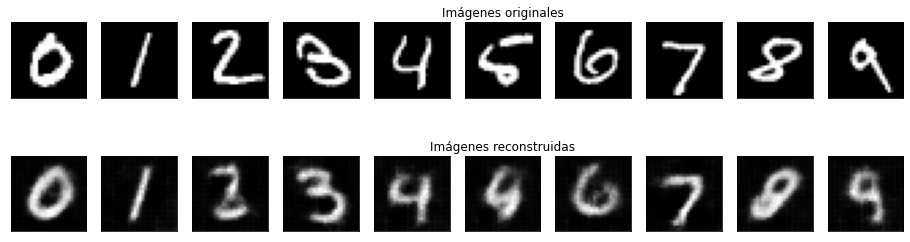


 EPOCH 2/30 	 train loss 0.03416277468204498 	 val loss 0.033128783106803894


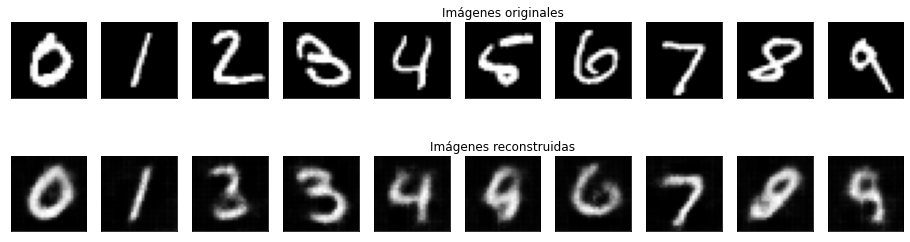


 EPOCH 3/30 	 train loss 0.0329289436340332 	 val loss 0.03223874419927597


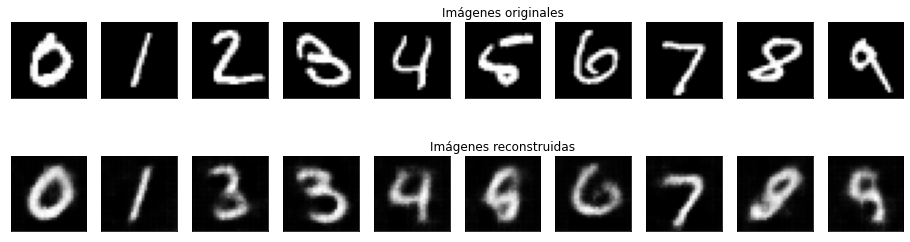


 EPOCH 4/30 	 train loss 0.03206121549010277 	 val loss 0.03161625191569328


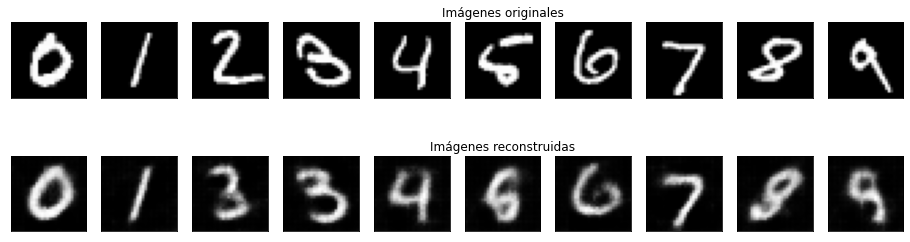


 EPOCH 5/30 	 train loss 0.03145595267415047 	 val loss 0.031236527487635612


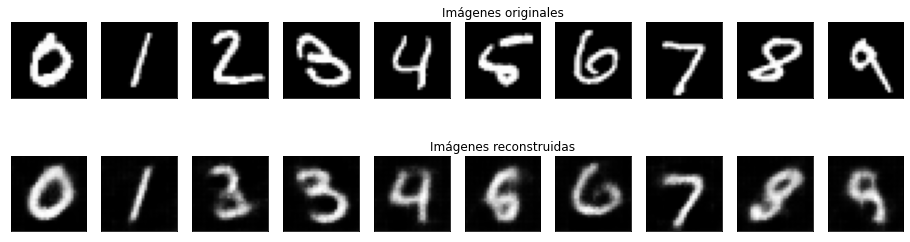


 EPOCH 6/30 	 train loss 0.030955372378230095 	 val loss 0.030998576432466507


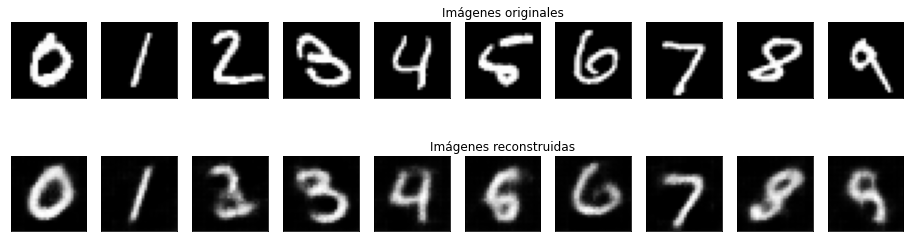


 EPOCH 7/30 	 train loss 0.03055550530552864 	 val loss 0.030657127499580383


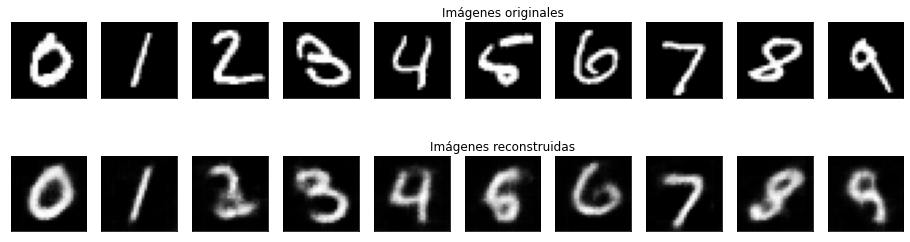


 EPOCH 8/30 	 train loss 0.030230309814214706 	 val loss 0.030284609645605087


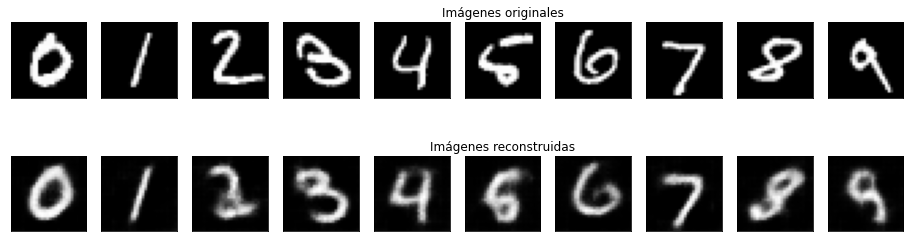


 EPOCH 9/30 	 train loss 0.02993992529809475 	 val loss 0.03005506657063961


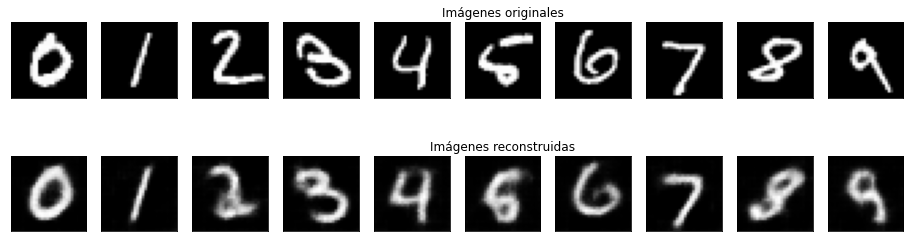


 EPOCH 10/30 	 train loss 0.029707886278629303 	 val loss 0.029815737158060074


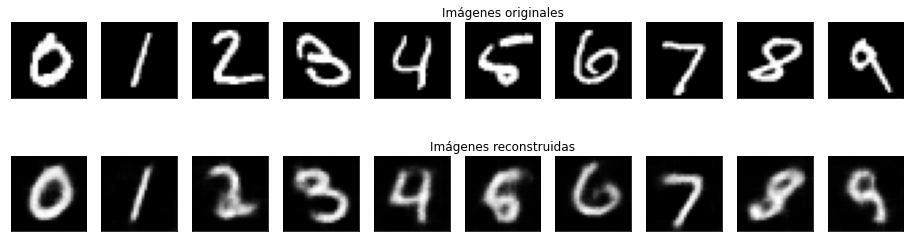


 EPOCH 11/30 	 train loss 0.0294929388910532 	 val loss 0.02967902645468712


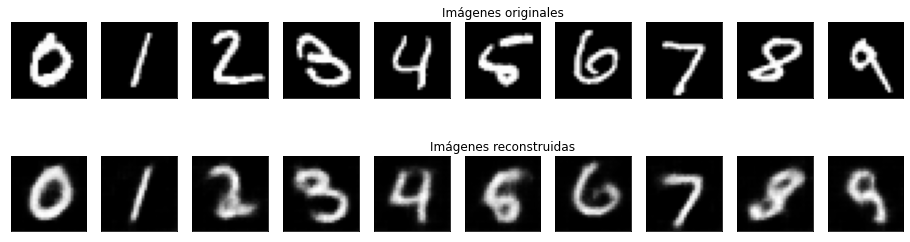


 EPOCH 12/30 	 train loss 0.029305901378393173 	 val loss 0.029481202363967896


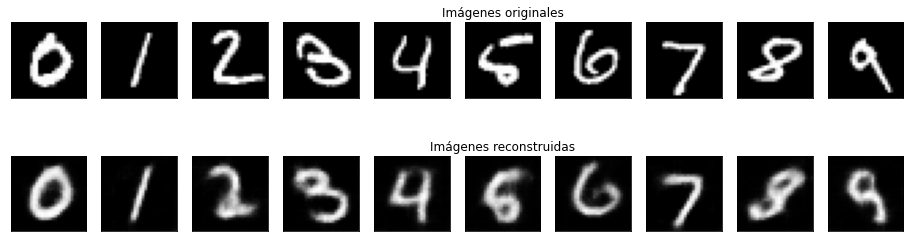


 EPOCH 13/30 	 train loss 0.02914229780435562 	 val loss 0.02932502143085003


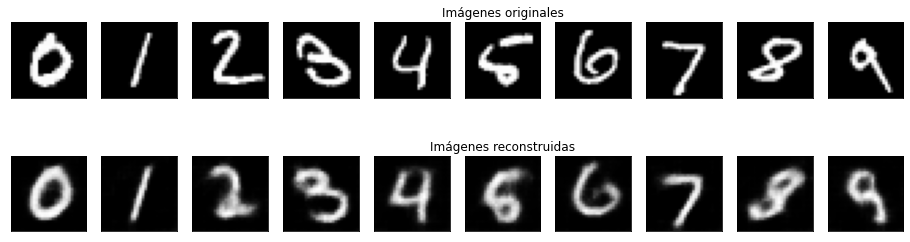


 EPOCH 14/30 	 train loss 0.028994033113121986 	 val loss 0.02916102483868599


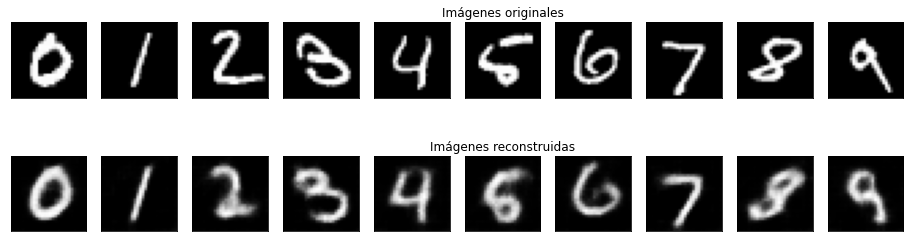


 EPOCH 15/30 	 train loss 0.0288426261395216 	 val loss 0.029068518429994583


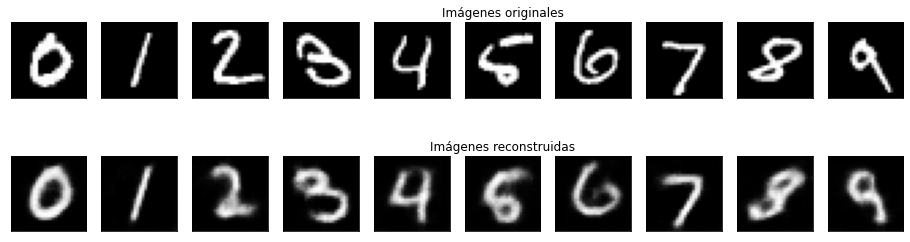


 EPOCH 16/30 	 train loss 0.028718672692775726 	 val loss 0.029096471145749092


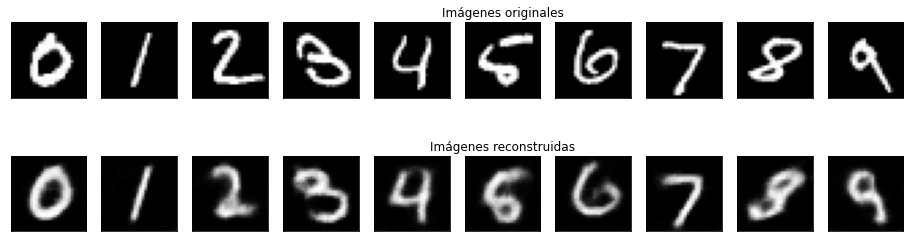


 EPOCH 17/30 	 train loss 0.028594067320227623 	 val loss 0.02885926514863968


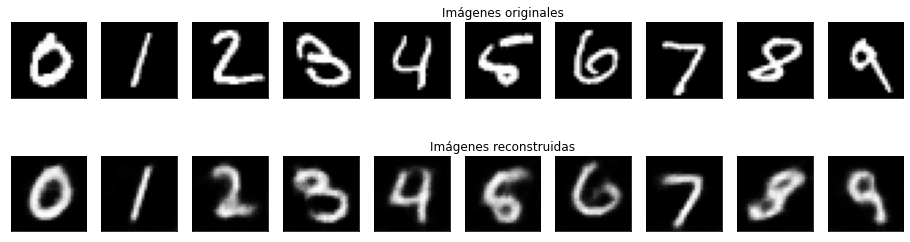


 EPOCH 18/30 	 train loss 0.02847963757812977 	 val loss 0.0287692341953516


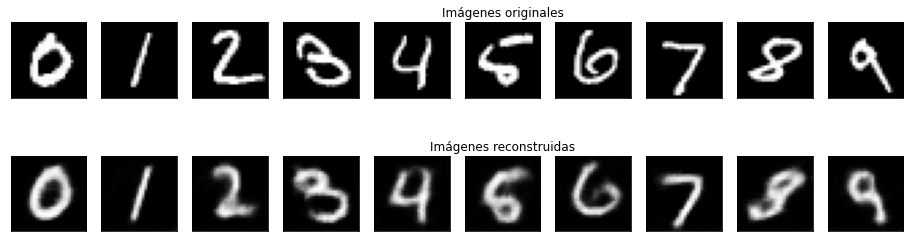


 EPOCH 19/30 	 train loss 0.028367595747113228 	 val loss 0.028657061979174614


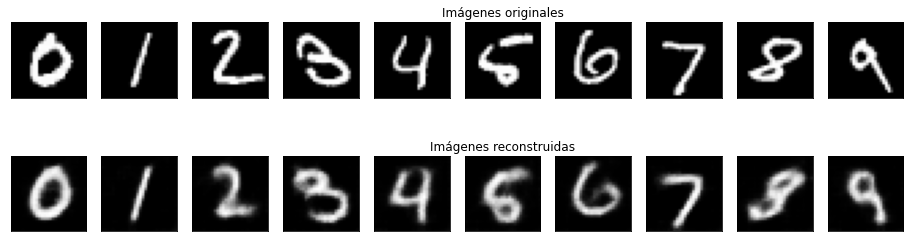


 EPOCH 20/30 	 train loss 0.028279198333621025 	 val loss 0.028666933998465538


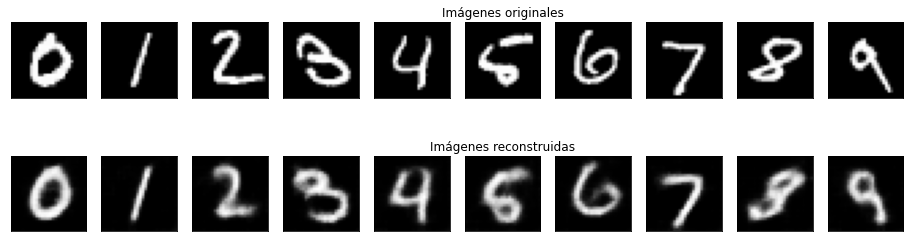


 EPOCH 21/30 	 train loss 0.0281846821308136 	 val loss 0.028599249199032784


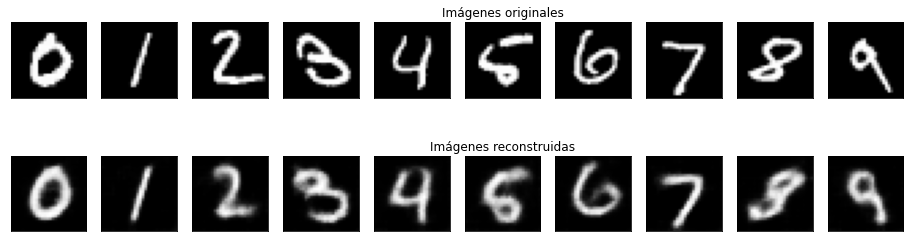


 EPOCH 22/30 	 train loss 0.028098421171307564 	 val loss 0.028522426262497902


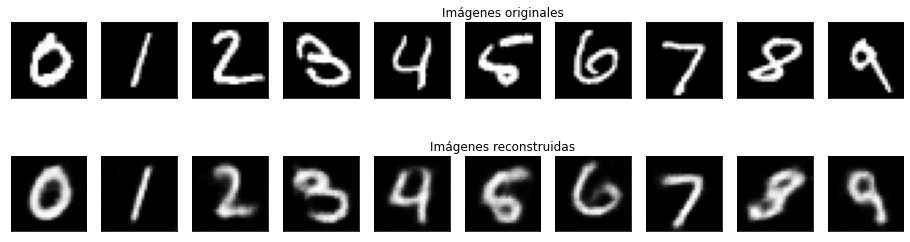


 EPOCH 23/30 	 train loss 0.02800942212343216 	 val loss 0.028493769466876984


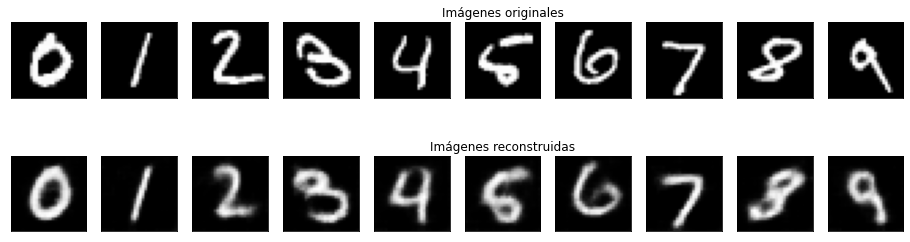


 EPOCH 24/30 	 train loss 0.027933532372117043 	 val loss 0.028421131893992424


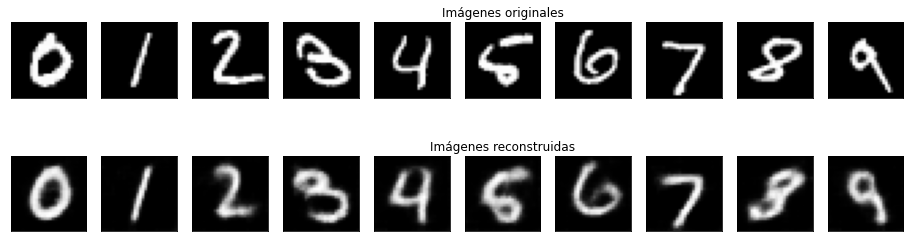


 EPOCH 25/30 	 train loss 0.027859412133693695 	 val loss 0.028326330706477165


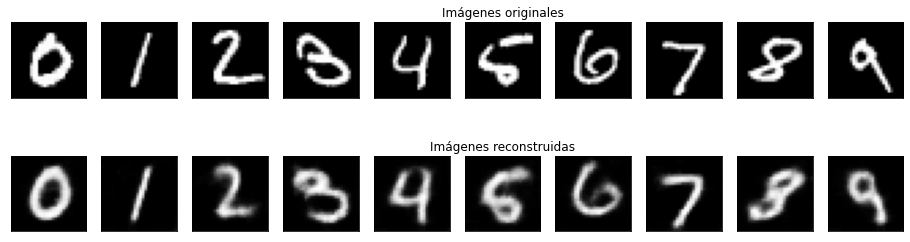


 EPOCH 26/30 	 train loss 0.027788223698735237 	 val loss 0.0282216165214777


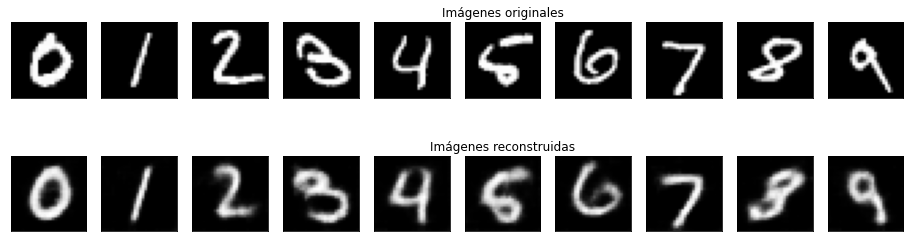


 EPOCH 27/30 	 train loss 0.027722662314772606 	 val loss 0.02828943356871605


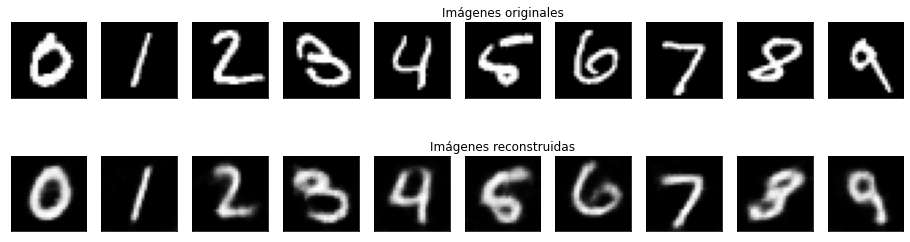


 EPOCH 28/30 	 train loss 0.02764546126127243 	 val loss 0.028206897899508476


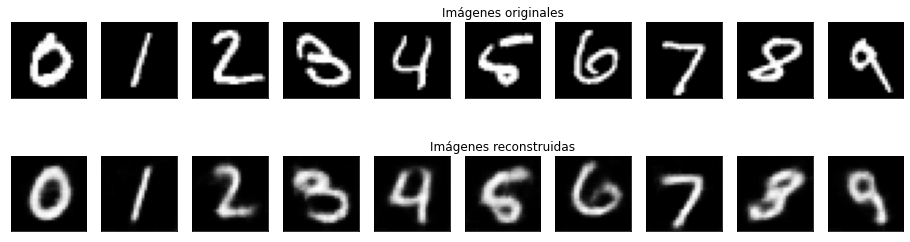


 EPOCH 29/30 	 train loss 0.027591770514845848 	 val loss 0.028155889362096786


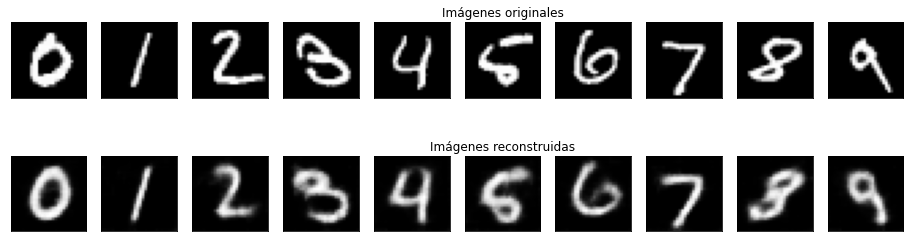


 EPOCH 30/30 	 train loss 0.02752559818327427 	 val loss 0.028002355247735977


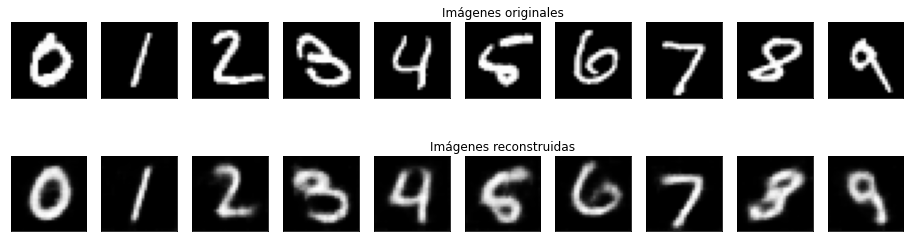

In [32]:
from tqdm.notebook import tqdm

num_epochs = 30

diz_loss = {'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
   train_loss =train_epoch(encoder, decoder, device,
   train_loader, loss_fn, optim)
   val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs, train_loss, val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder, decoder, n=10)

In [10]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item()

0.0268623698502779

## Definir función para visualizar las pérdidas

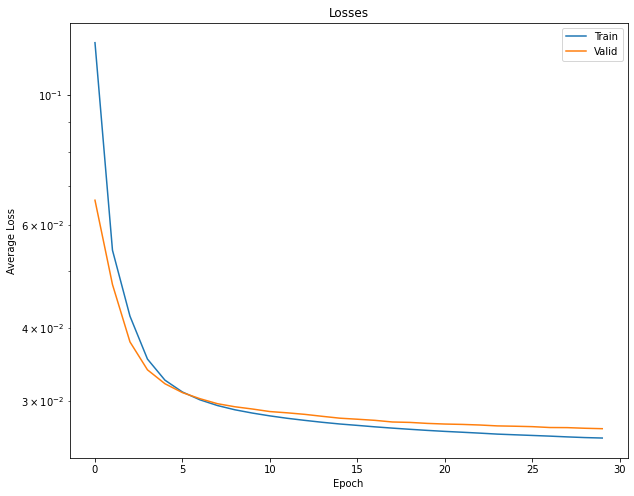

In [11]:
# función para graficar las pérdidas
# https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.semilogy.html
# plt.semilogy: realiza una gráfica con escala logarítmica en el eje y.

def plot_Losses():
  plt.figure(figsize=(10,8))
  plt.semilogy(diz_loss['train_loss'], label='Train')
  plt.semilogy(diz_loss['val_loss'], label='Valid')
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss')
  #plt.grid()
  plt.legend()
  plt.title('Losses')
  plt.show()

plot_Losses()

## Generar nuevas muestras a partir del código latente

Para generar nuevas imágenes a partir del código latente, tomamos muestras al azar de una distribución normal con la media y la desviación estándar de los datos codificados. Estas muestras se pasarán al decodificador, que creará las imágenes reconstruidas.

tensor([-0.4046, -0.1929, -0.4153,  0.0948])
tensor([0.5975, 0.7095, 0.8367, 0.7143])


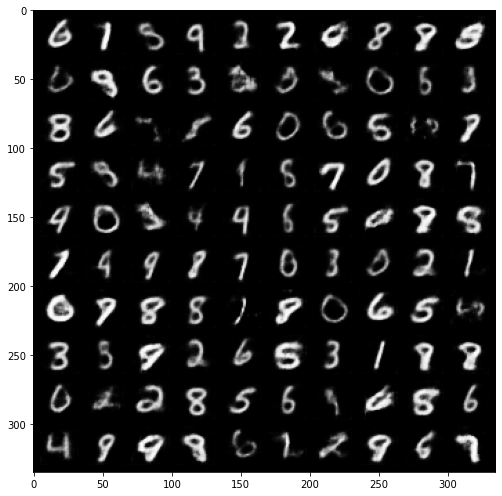

In [33]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calcular la media y el la desviación estándar del código latente generado tomando imágenes de prueba como entradas
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # muestra vectores latentes de la distribución normal
    latent = torch.randn(128, d)*std + mean

    # reconstruir imágenes a partir de los vectores latentes aleatorios
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()